In [1]:
from opm_acquire import cams
from pyDCAM import *

In [4]:


device_count = dcamapi_init()
print("dcamapi_init() found {} device(s).".format(device_count))

for i_device in range(device_count):
    with HDCAM(i_device) as hdcam:
        model = hdcam.dcamdev_getstring(DCAM_IDSTR.DCAM_IDSTR_MODEL)
        camera_id = hdcam.dcamdev_getstring(DCAM_IDSTR.DCAM_IDSTR_CAMERAID)
        bus = hdcam.dcamdev_getstring(DCAM_IDSTR.DCAM_IDSTR_BUS)

    print("{} ({}) on {}".format(model, camera_id, bus))

dcamapi_uninit()


dcamapi_init() found 1 device(s).
C13440-20CU (S/N: 302496) on USB3


In [7]:
with use_dcamapi:
    with HDCAM(i_device) as hdcam:
        for prop_id in hdcam.dcamprop_ids():
            name = hdcam.dcamprop_getname(prop_id)
            value = hdcam.dcamprop_getvalue(prop_id)
            

            print(prop_id, name, value)


4194832 SENSOR MODE 1.0
4194576 READOUT SPEED 2.0
4194608 READOUT DIRECTION 5.0
4325664 COLORTYPE 1.0
4325680 BIT PER CHANNEL 16.0
1048848 TRIGGER SOURCE 1.0
1049104 TRIGGER MODE 1.0
1048864 TRIGGER ACTIVE 1.0
2032384 TRIGGER GLOBAL EXPOSURE 3.0
1049120 TRIGGER POLARITY 1.0
1049136 TRIGGER CONNECTOR 2.0
1049152 TRIGGER TIMES 1.0
1049184 TRIGGER DELAY 0.0
1049200 INTERNAL TRIGGER HANDLING 1.0
2097936 SENSOR TEMPERATURE -10.0
2097984 SENSOR COOLER STATUS 2.0
2031888 EXPOSURE TIME 0.009997714285714287
4653072 DEFECT CORRECT MODE 2.0
4653104 HOT PIXEL CORRECT LEVEL 1.0
4198672 BINNING 1.0
4202768 SUBARRAY HPOS 0.0
4202784 SUBARRAY HSIZE 2048.0
4202800 SUBARRAY VPOS 0.0
4202816 SUBARRAY VSIZE 2048.0
4202832 SUBARRAY MODE 1.0
3671312 INTENSITY LUT MODE 1.0
3671328 INTENSITY LUT PAGE 1.0
4195872 EXTRACTION MODE 1.0
4206608 TIMING READOUT TIME 0.024994285714285715
4206624 TIMING CYCLIC TRIGGER PERIOD 0.0
4206640 TIMING MIN TRIGGER BLANKING 0.0
4206672 TIMING MIN TRIGGER INTERVAL 0.024994285714

In [19]:
with use_dcamapi:
    with HDCAM(i_device) as hdcam:
        horzsize = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_IMAGE_HEIGHT)
        vertsize = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_IMAGE_WIDTH)
        yoffs = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_SUBARRAYHPOS)
        xoffs = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_SUBARRAYVPOS)
        print(horzsize, vertsize, yoffs, xoffs)

2048.0 2048.0 0.0 0.0


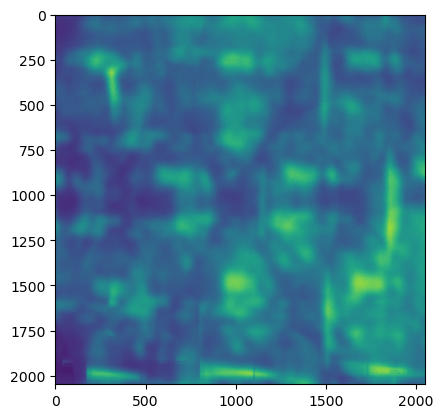

In [4]:
import matplotlib.pyplot as plt
with use_dcamapi:
    with HDCAM(i_device) as hdcam:

        # Configure the readout speed. Use slowest option for the ultraquite mode
        hdcam.readout_speed = DCAMPROPMODEVALUE.DCAMPROP_READOUTSPEED__SLOWEST

        hdcam.dcambuf_alloc(1)

        hwait = hdcam.dcamwait_open()

        hdcam.dcamcap_start()

        # Wait for the frame to be ready, it has a timeout of 1000 millisec
        hwait.dcamwait_start(timeout=1000)

        # Copy the frame from the internal buffer to create a numpy array
        array = hdcam.dcambuf_copyframe()

        # Stop the capture and release the buffer
        hdcam.dcamcap_stop()
        hdcam.dcambuf_release()

        # Display the image
        plt.imshow(array)
        plt.show()

In [20]:
with use_dcamapi:
        with HDCAM(i_device) as hdcam:

            # Configure the readout speed. Use slowest option for the ultraquite mode
            hdcam.readout_speed = DCAMPROPMODEVALUE.DCAMPROP_READOUTSPEED__SLOWEST

            hdcam.subarray_mode = True # Enable subarray mode
            hdcam.subarray_size = (100, 100) # 100x100 pixels
            hdcam.subarray_pos = (200, 200) # 200 pixels from the top-left corner
            horzsize = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_IMAGE_HEIGHT)
            vertsize = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_IMAGE_WIDTH)
            yoffs = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_SUBARRAYHPOS)
            xoffs = hdcam.dcamprop_getvalue(DCAMIDPROP.DCAM_IDPROP_SUBARRAYVPOS)
            print(horzsize, vertsize, yoffs, xoffs)

            hdcam.dcambuf_alloc(1)

            hwait = hdcam.dcamwait_open()

            hdcam.dcamcap_start()

            # Wait for the frame to be ready, it has a timeout of 1000 millisec
            hwait.dcamwait_start(timeout=1000)

            # Copy the frame from the internal buffer to create a numpy array
            array = hdcam.dcambuf_copyframe()

            # Stop the capture and release the buffer
            hdcam.dcamcap_stop()
            hdcam.dcambuf_release()

            # Display the image
            plt.imshow(array)
            plt.show()


100.0 100.0 200.0 200.0


NameError: name 'plt' is not defined

5
4
3
2
1
Firing software trigger


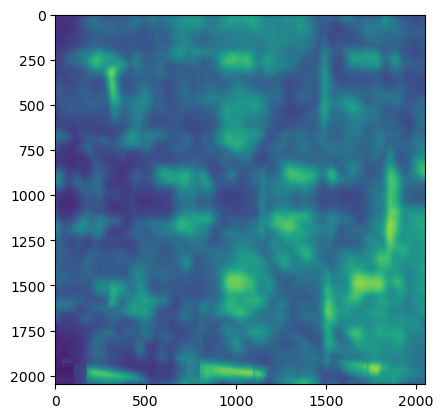

In [7]:
from collections.abc import Callable, Iterable, Mapping
from typing import Any

import time
import threading

with use_dcamapi:
    with HDCAM(i_device) as hdcam:

        # Use the software trigger. Alternatively, use DCAMPROP_TRIGGERSOURCE__EXTERNAL
        # to use the external trigger.
        hdcam.dcamprop_setvalue(DCAMIDPROP.DCAM_IDPROP_TRIGGERSOURCE,
            DCAMPROPMODEVALUE.DCAMPROP_TRIGGERSOURCE__SOFTWARE
        )

        delay = 5

        class FireSoftwareTrigger(threading.Thread):
            def run(self):
                for i in range(delay, 0, -1):
                    print(i)
                    time.sleep(1)

                print("Firing software trigger")
                hdcam.dcamcap_firetrigger()


        hdcam.dcambuf_alloc(1)

        hwait = hdcam.dcamwait_open()

        hdcam.dcamcap_start()

        # Firing the software trigger from a separate thread
        FireSoftwareTrigger().start()

        # Blocking until the software trigger is fired
        hwait.dcamwait_start()

        array = hdcam.dcambuf_copyframe()

        hdcam.dcamcap_stop()
        hdcam.dcambuf_release()

        plt.imshow(array)
        plt.show()